# readme
descrip: plot steric height increase (future minus historic time) and bathymetry in the North Atlantic for Sunway transient and control runs <br>

update history: <br>
v1.0 DL 2021Mar30 <br>
v1.1 DL 2021Apr05 <br>
v1.2 DL 2021Apr25 <br>
v1.3 DL 2021Apr27 <br>
v1.4 DL 2021May11 make publication-ready pic <br>
v1.5 DL 2021May21 combine steric height increases and bathymetry bias into one fig <br>

extra notes: <br>
Fig 1 LR and HR steric heights and bathymetry difference <br>
(maybe) Fig 2 LR and HR SSH and steric heights (remove global mean steric height)

# import modules

In [1]:
# general python packages
import numpy as np
import xarray as xr
# import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib.patches as mpatches
%matplotlib inline
import proplot as plot
import cartopy
cartopy.config['pre_existing_data_dir']='/scratch/group/ihesp/shared/cartopy_features'
# import cartopy.crs as ccrs
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid

# python GCM(POP) packages
# import xgcm
# import pop_tools
import xesmf as xe

# from eofs.xarray import Eof

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.232:45060")
client

<Client: 'tcp://10.73.3.232:45060' processes=10 threads=10, memory=210.00 GB>

In [3]:
def pop_add_cyclic(ds):
    '''readme: copied by DL on 2021Apr13 from Matt Long github 
    https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c'''
    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data
    
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)    
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.        
    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})

    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso

# read data

In [4]:
chunks_HR = {'nlat':800,'nlon':900}
chunks_LR = {'nlat':384,'nlon':320}

# North Atlantic
lat1, lat2 = 20, 65 
lon1, lon2 = -85, -15 # 85W - 15W
outdir='/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'StericHeightBathymetryNorthAtlantic_2021May21.png'

read steric height files <br>
control HR (CH)

In [5]:
infile_h_rst_CH = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_RegionalStericHeight250-500_2021May21.nc')
# infiles_TH
ds_h_rst_CH = xr.open_dataset(infile_h_rst_CH, chunks=chunks_HR)
ds_h_rst_CH

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 251)
Coordinates:
  * time     (time) object 0250-12-31 00:00:00 ... 0500-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(251, 800, 900), meta=np.ndarray>

transient HR (TH)

In [6]:
infile_h_rst_TH = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway_RegionalStericHeight1850-2100_2021May21.nc')
# infiles_TH
ds_h_rst_TH = xr.open_dataset(infile_h_rst_TH, chunks=chunks_HR)
ds_h_rst_TH

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 251)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(800, 900), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(251, 800, 900), meta=np.ndarray>

In [7]:
infile0_HR = ('/scratch/group/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/'
              'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0250-01.nc')
ds0_HR = xr.open_dataset(infile0_HR)
ds0_HR

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time                (time) object 0250-02-01 00:00:00
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 ...
    ULAT                (nlat, nlon) float64 ...
    TLONG               (nlat, nlon) float64 ...
    TLAT                (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/87)
    time_bound          (time, d2) object ...
    dz                  (z_t) float32 ...
    dzw                 (z_w) float32 ...
    KMT                 (nlat, nlon) float64 ...
    KMU                 (nlat, nlon) float64 ...
    REGION_MASK         (nlat, nlon) float64 ...
    ...                  ...
    HMXL                (time, nlat, nlon) float32 ...
    XMXL                (time, nlat, nlon) float32 ...
    TMXL                (time, nlat, nlon) float32 ...
    HBLT                (time, nlat, nlon) float32 ...
    XBLT                (time, nlat, nlon) float32 ...
    TBLT                (time, nlat, nlon) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2019-10-05 at 03:26:45.4
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    52176371
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0

transient LR 

In [8]:
infile_h_rst_TL = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway_RegionalStericHeight1850-2100_2021May21.nc')
ds_h_rst_TL = xr.open_dataset(infile_h_rst_TL, chunks=chunks_LR)
ds_h_rst_TL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 250)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(250, 384, 320), meta=np.ndarray>

Control LR (CL)

In [9]:
infile_h_rst_CL = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.B1850C5.ne30g16.sehires38.003.sunway_RegionalStericHeight250-500_2021May21.nc')
ds_h_rst_CL = xr.open_dataset(infile_h_rst_CL, chunks=chunks_LR)
ds_h_rst_CL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 246)
Coordinates:
  * time     (time) object 0250-12-31 00:00:00 ... 0500-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(246, 384, 320), meta=np.ndarray>

In [10]:
infile0_LR = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/'
              'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')
ds0_LR = xr.open_dataset(infile0_LR)
ds0_LR

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat: 384, nlon: 320, time: 1, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/14)
  * time                  (time) object 1850-02-01 00:00:00
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ...                    ...
    transport_components  (transport_comp, nchar) |S1 ...
    transport_regions     (transport_reg, nchar) |S1 ...
    ULONG                 (nlat, nlon) float64 ...
    ULAT                  (nlat, nlon) float64 ...
    TLONG                 (nlat, nlon) float64 ...
    TLAT                  (nlat, nlon) float64 ...
Dimensions without coordinates: d2, moc_comp, nchar, nlat, nlon, transport_comp, transport_reg
Data variables: (12/137)
    time_bound            (time, d2) object ...
    moc_components        (moc_comp, nchar) |S1 ...
    dz                    (z_t) float32 ...
    dzw                   (z_w) float32 ...
    KMT                   (nlat, nlon) float64 ...
    KMU                   (nlat, nlon) float64 ...
    ...                    ...
    XBLT                  (time, nlat, nlon) float32 ...
    TBLT                  (time, nlat, nlon) float32 ...
    BSF                   (time, nlat, nlon) float32 ...
    MOC                   (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
    N_HEAT                (time, transport_reg, transport_comp, lat_aux_grid) float32 ...
    N_SALT                (time, transport_reg, transport_comp, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

read ETOPO5 bathymetry

In [11]:
infile_etopo = '/scratch/user/dapengli/obs_dat/bathymetry_ETOPO5_2021Apr27/data.nc'
ds_etopo = xr.open_dataset(infile_etopo)
ds_etopo

<xarray.Dataset>
Dimensions:  (X: 4320, Y: 2160)
Coordinates:
  * X        (X) float32 0.0 0.08333 0.1667 0.25 ... 359.7 359.8 359.8 359.9
  * Y        (Y) float32 90.0 89.92 89.83 89.75 ... -89.67 -89.75 -89.83 -89.92
Data variables:
    elev     (Y, X) int16 ...

In [12]:
ds_etopo_rn = ds_etopo.rename({'X': 'lon', 'Y': 'lat'}) # rn: rename
ds_etopo_rn

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320)
Coordinates:
  * lon      (lon) float32 0.0 0.08333 0.1667 0.25 ... 359.7 359.8 359.8 359.9
  * lat      (lat) float32 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
Data variables:
    elev     (lat, lon) int16 ...

<xarray.DataArray 'elev' (lat: 2160, lon: 4320)>
array([[4290., 4290., 4290., ..., 4290., 4290., 4290.],
       [4288., 4288., 4288., ..., 4288., 4288., 4288.],
       [4288., 4288., 4288., ..., 4287., 4287., 4287.],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])
Coordinates:
  * lon      (lon) float32 0.0 0.08333 0.1667 0.25 ... 359.7 359.8 359.8 359.9
  * lat      (lat) float32 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
Attributes:
    units:           m
    long_name:       elevation/bathymetry
    maxncolor:       253
    CS:              -9964.0
    CE:              7964.0
    ncolor:          253
    scale_min:       -9964.0
    scale_max:       7964.0
    colormap:        [0 1973790 4026644 [4026644 28] 9125192 [9125192 28] [15...
    colorscalename:  topographycolorscale

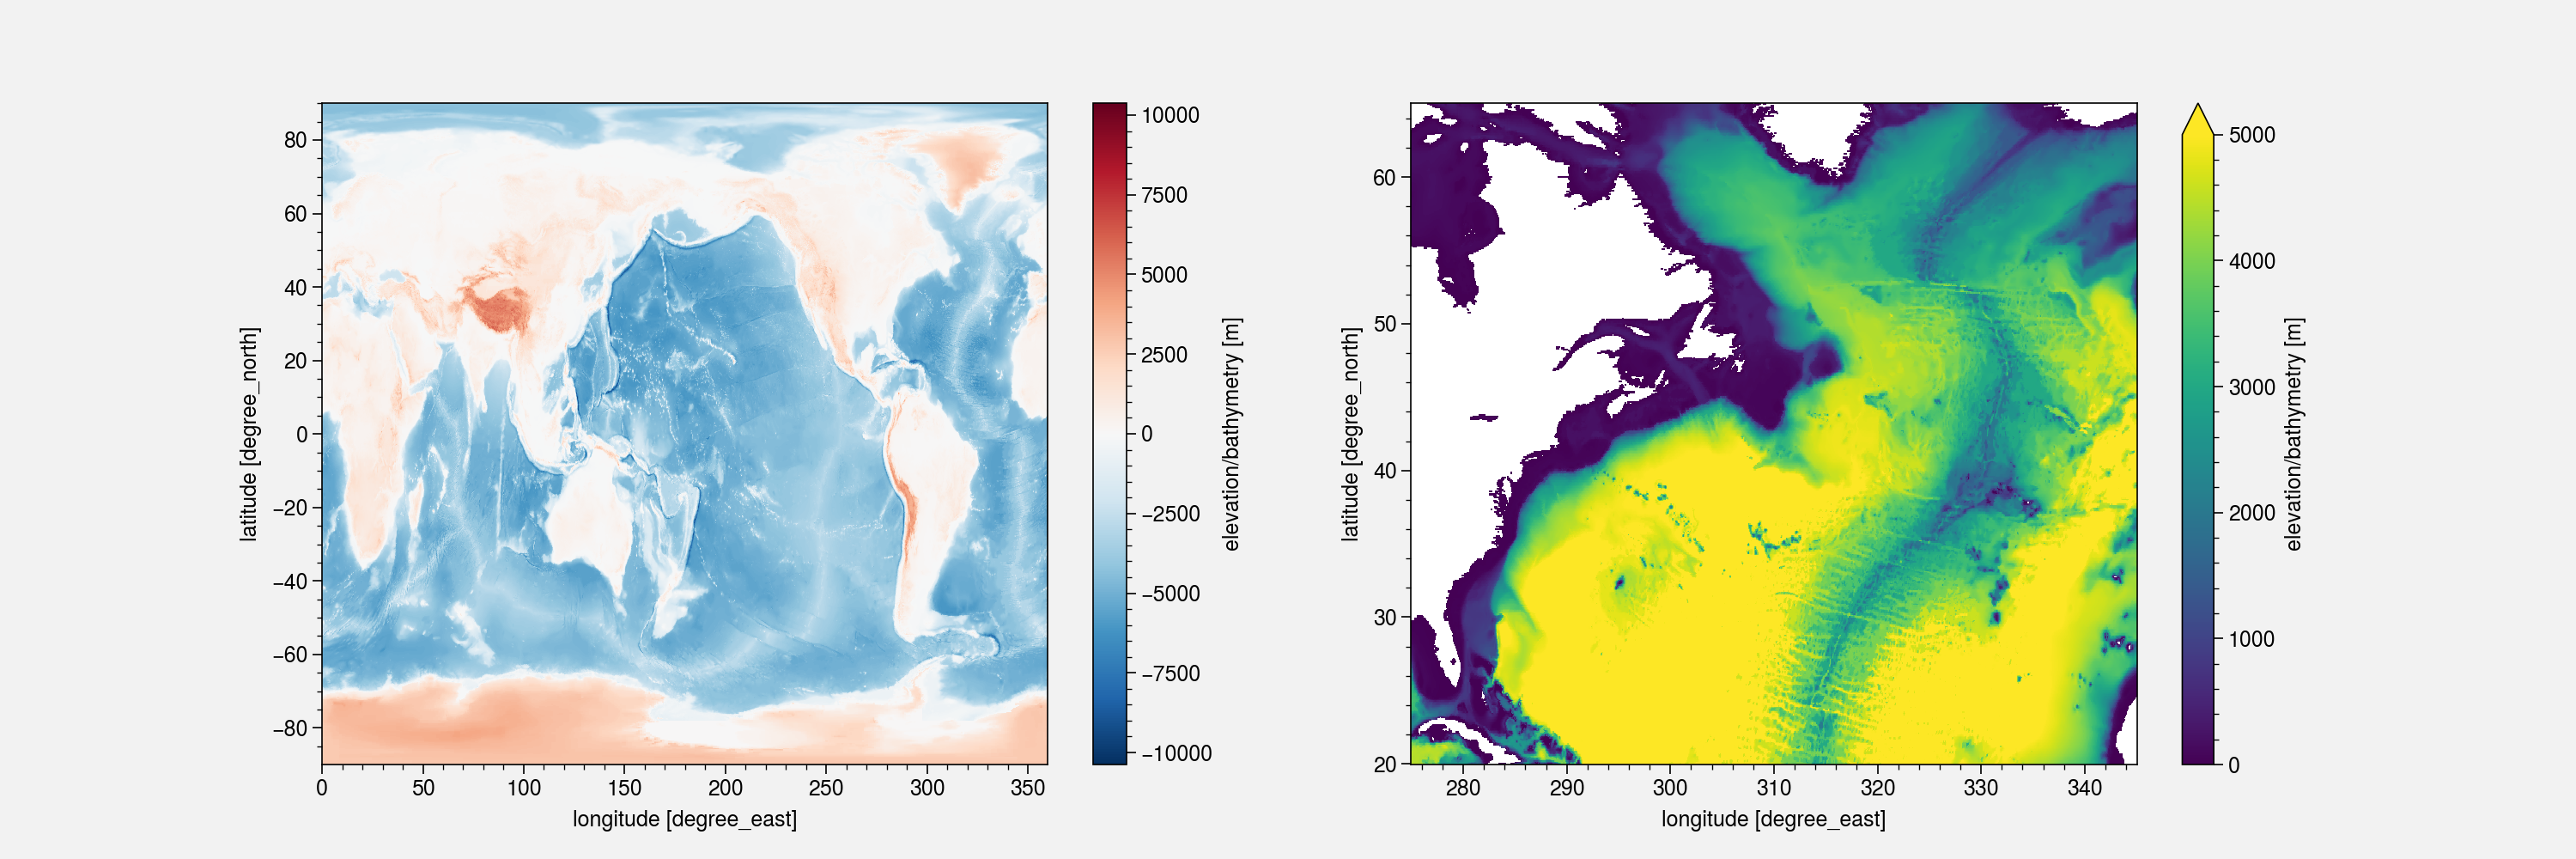

In [13]:
bathy_etopo=ds_etopo_rn.elev
bathy_etopo=-bathy_etopo.where(ds_etopo_rn.elev<0,np.nan) 
# mask land topo as nan, make bathy positive values

fig, axs = plt.subplots(1,2,figsize=(15,5))
ds_etopo.elev.plot(ax=axs[0])
bathy_NA_etopo = bathy_etopo.sel(lon=slice(lon1+360,lon2+360),
                                 lat=slice(lat2,lat1))
bathy_NA_etopo.plot(ax=axs[1],vmin=0,vmax=5000)
bathy_etopo

In [14]:
infile0_g16 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds0_g16 = xr.open_dataset(infile0_g16)
# ds0_g16

infile0_t12 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds0_t12 = xr.open_dataset(infile0_t12)
# ds0_t12

ds0_g16_rn = ds0_g16.rename({'TLONG': 'lon', 'TLAT': 'lat'}) # rn: rename
ds0_t12_rn = ds0_t12.rename({'TLONG': 'lon', 'TLAT': 'lat'})
weightfile_t12_g16deg = ('/scratch/user/dapengli/Projects4iHESP/'
                       'Project_SeaLevelUSEastCoast_2021Mar30/python_scripts/'
                      'bilinear_POPt12_g16_Global_periodic_2021Apr12.nc')
regridder_t12_g16deg = xe.Regridder(ds0_t12_rn, ds0_g16_rn, method='bilinear', 
                                    periodic=True, filename=weightfile_t12_g16deg, 
                                    reuse_weights=True) # 
# regridder_t12_g16deg

In [15]:
weightfile_std5min_t12deg = ('/scratch/user/dapengli/Projects4iHESP/'
                       'Project_SeaLevelUSEastCoast_2021Mar30/python_scripts/'
                       'bilinear_std5min_t12_Global_periodic_2021May21.nc')
regridder_std5min_t12deg = xe.Regridder(ds_etopo_rn, ds0_t12_rn, method='bilinear', 
                                    periodic=True, filename=weightfile_std5min_t12deg, 
                                    reuse_weights=True)
bathy_etopo_t12 = regridder_std5min_t12deg(bathy_etopo)
bathy_etopo_t12

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/xesmf/frontend.py:476: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


<xarray.DataArray 'elev' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (nlat, nlon) float64 250.1 250.2 250.2 250.3 ... 250.0 250.0 250.0
    lat      (nlat, nlon) float64 -78.47 -78.47 -78.47 ... 62.34 62.34 62.34
Dimensions without coordinates: nlat, nlon
Attributes:
    regrid_method:  bilinear

In [16]:
weightfile_std5min_g16deg = ('/scratch/user/dapengli/Projects4iHESP/'
                       'Project_SeaLevelUSEastCoast_2021Mar30/python_scripts/'
                       'bilinear_std5min_g16_Global_periodic_2021May21.nc')
regridder_std5min_g16deg = xe.Regridder(ds_etopo_rn, ds0_g16_rn, method='bilinear', 
                                    periodic=True, filename=weightfile_std5min_g16deg, 
                                    reuse_weights=True)
bathy_etopo_g16 = regridder_std5min_g16deg(bathy_etopo)
bathy_etopo_g16 = bathy_etopo_g16.rename({'lon': 'TLONG', 'lat': 'TLAT'})
bathy_etopo_g16

<xarray.DataArray 'elev' (nlat: 384, nlon: 320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Attributes:
    regrid_method:  bilinear

# data analysis 

In [17]:
h_rst1_TH = ds_h_rst_TH.h_rst.sel(time=slice('2001','2020')).mean('time')
# h_rst1_gl_av_TH = h_rst1_TH.weighted(ds0_HR.TAREA).mean(("nlon", "nlat"))
# h_rsta1_TH = h_rst1_TH #- h_rst1_gl_av_TH

h_rst2_TH = ds_h_rst_TH.h_rst.sel(time=slice('2081','2100')).mean('time')
# h_rst2_gl_av_TH = h_rst2_TH.weighted(ds0_HR.TAREA).mean(("nlon", "nlat"))
# h_rsta2_TH = h_rst2_TH #- h_rst2_gl_av_TH

dh_rst_TH = (h_rst2_TH-h_rst1_TH).compute()
# force to compute for xesmf
dh_rst_TH = dh_rst_TH.drop(['ULONG','ULAT'])
dh_rst_TH

<xarray.DataArray 'h_rst' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

In [18]:
# h_rst1_CH = ds_CH.h_rst.sel(time=slice('2001','2020')).mean('time')
# # h_rst1_gl_av_CH = h_rst1_CH.weighted(ds0_HR.TAREA).mean(("nlon", "nlat"))
# # h_rsta1_CH = h_rst1_CH #- h_rst1_gl_av_CH

# h_rst2_CH = ds_CH.h_rst.sel(time=slice('2081','2100')).mean('time')
# # h_rst2_gl_av_CH = h_rst2_CH.weighted(ds0_HR.TAREA).mean(("nlon", "nlat"))
# # h_rsta2_CH = h_rst2_CH #- h_rst2_gl_av_CH

# dh_rst_CH = (h_rst2_CH-h_rst1_CH).compute()
# dh_rst_CH

In [19]:
h_rst1_TL = ds_h_rst_TL.h_rst.sel(time=slice('2001','2020')).mean('time')
# h_rst1_gl_av_TL = h_rst1_TL.weighted(ds0_LR.TAREA).mean(("nlon", "nlat"))
# h_rsta1_TL = h_rst1_TL #- h_rst1_gl_av_TL

h_rst2_TL = ds_h_rst_TL.h_rst.sel(time=slice('2081','2100')).mean('time')
# h_rst2_gl_av_TL = h_rst2_TL.weighted(ds0_LR.TAREA).mean(("nlon", "nlat"))
# h_rsta2_TL = h_rst2_TL #- h_rst2_gl_av_TL

dh_rst_TL = (h_rst2_TL-h_rst1_TL).compute()
dh_rst_TL = dh_rst_TL.drop(['ULONG','ULAT'])
dh_rst_TL

<xarray.DataArray 'h_rst' (nlat: 384, nlon: 320)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [13.49126183, 13.47658563, 13.47560194, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon

In [20]:
# h_rst1_CL = ds1_CL.h_rst.mean('time')
# # h_rst1_gl_av_TL = h_rst1_TL.weighted(ds0_LR.TAREA).mean(("nlon", "nlat"))
# # h_rsta1_CL = h_rst1_CL #- h_rst1_gl_av_TL

# h_rst2_CL = ds2_CL.h_rst.mean('time')
# # h_rst2_gl_av_TL = h_rst2_TL.weighted(ds0_LR.TAREA).mean(("nlon", "nlat"))
# # h_rsta2_CL = h_rst2_CL #- h_rst2_gl_av_TL

# dh_rst_CL = (h_rst2_CL-h_rst1_CL).compute()
# dh_rst_CL

regrid t12 to g16 grids

In [21]:
# dh_rst_rgd_TH = regridder_t12_g16deg(dh_rst_TH.drop('ULONG').drop('ULAT')) 
dh_rst_rgd_TH = regridder_t12_g16deg(dh_rst_TH) 
dh_rst_THmTL = (dh_rst_rgd_TH - dh_rst_TL).drop(['lon','lat'])
dh_rst_THmTL 

dph_rst_THmTL = dh_rst_THmTL/dh_rst_TL
dph_rst_THmTL

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/xesmf/frontend.py:476: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


<xarray.DataArray 'h_rst' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.93055444, 1.16483667, 1.31739912, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon

In [22]:
# dh_rst_THmTL = dh_rst_rgd_TH.rename({'lon': 'TLONG', 'lat': 'TLAT'}) - dh_rst_TL.drop('ULONG').drop('ULAT')
# dh_rst_rgd_THmTL
# dh_rst_THmTL = dh_rst_rgd_TH.rename({'lon': 'TLONG', 'lat': 'TLAT'}) - dh_rst_TL
# dh_rst_THmTL
# dh_rst_TL
# dh_rst_TL.drop('ULONG').drop('ULAT')
# dh_rst_rgd_TH.rename({'lon': 'TLONG', 'lat': 'TLAT'})

In [23]:
ds0_g16['dh_rst_TL'] = dh_rst_TL
ds0_g16['dh_rst_THmTL'] = dh_rst_THmTL
ds0_g16['dph_rst_THmTL'] = dph_rst_THmTL
ds0_g16['bathy_etopo_g16'] = bathy_etopo_g16
ds0_g16['HT'] = ds0_LR.HT.drop('ULONG').drop('ULAT')
ds0_g16_ac = pop_add_cyclic(ds0_g16) # ac: add cyclic
ds0_g16_ac

<xarray.Dataset>
Dimensions:          (nlat: 384, nlon: 321, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t              (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w              (z_w) float64 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot          (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT             (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31
    TLONG            (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 -39.86
    ULAT             (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 80.03 80.03
    ULONG            (nlat, nlon) float64 140.0 141.1 142.3 ... 320.3 320.0
    DXT              (nlat, nlon) float64 2.339e+06 2.339e+06 ... 5.335e+05
    DYT              (nlat, nlon) float64 5.94e+06 5.94e+06 ... 6.263e+06
    ...               ...
    dz               (z_t) float64 ...
    dh_rst_TL        (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    dh_rst_THmTL     (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    dph_rst_THmTL    (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    bathy_etopo_g16  (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    HT               (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

# make pics

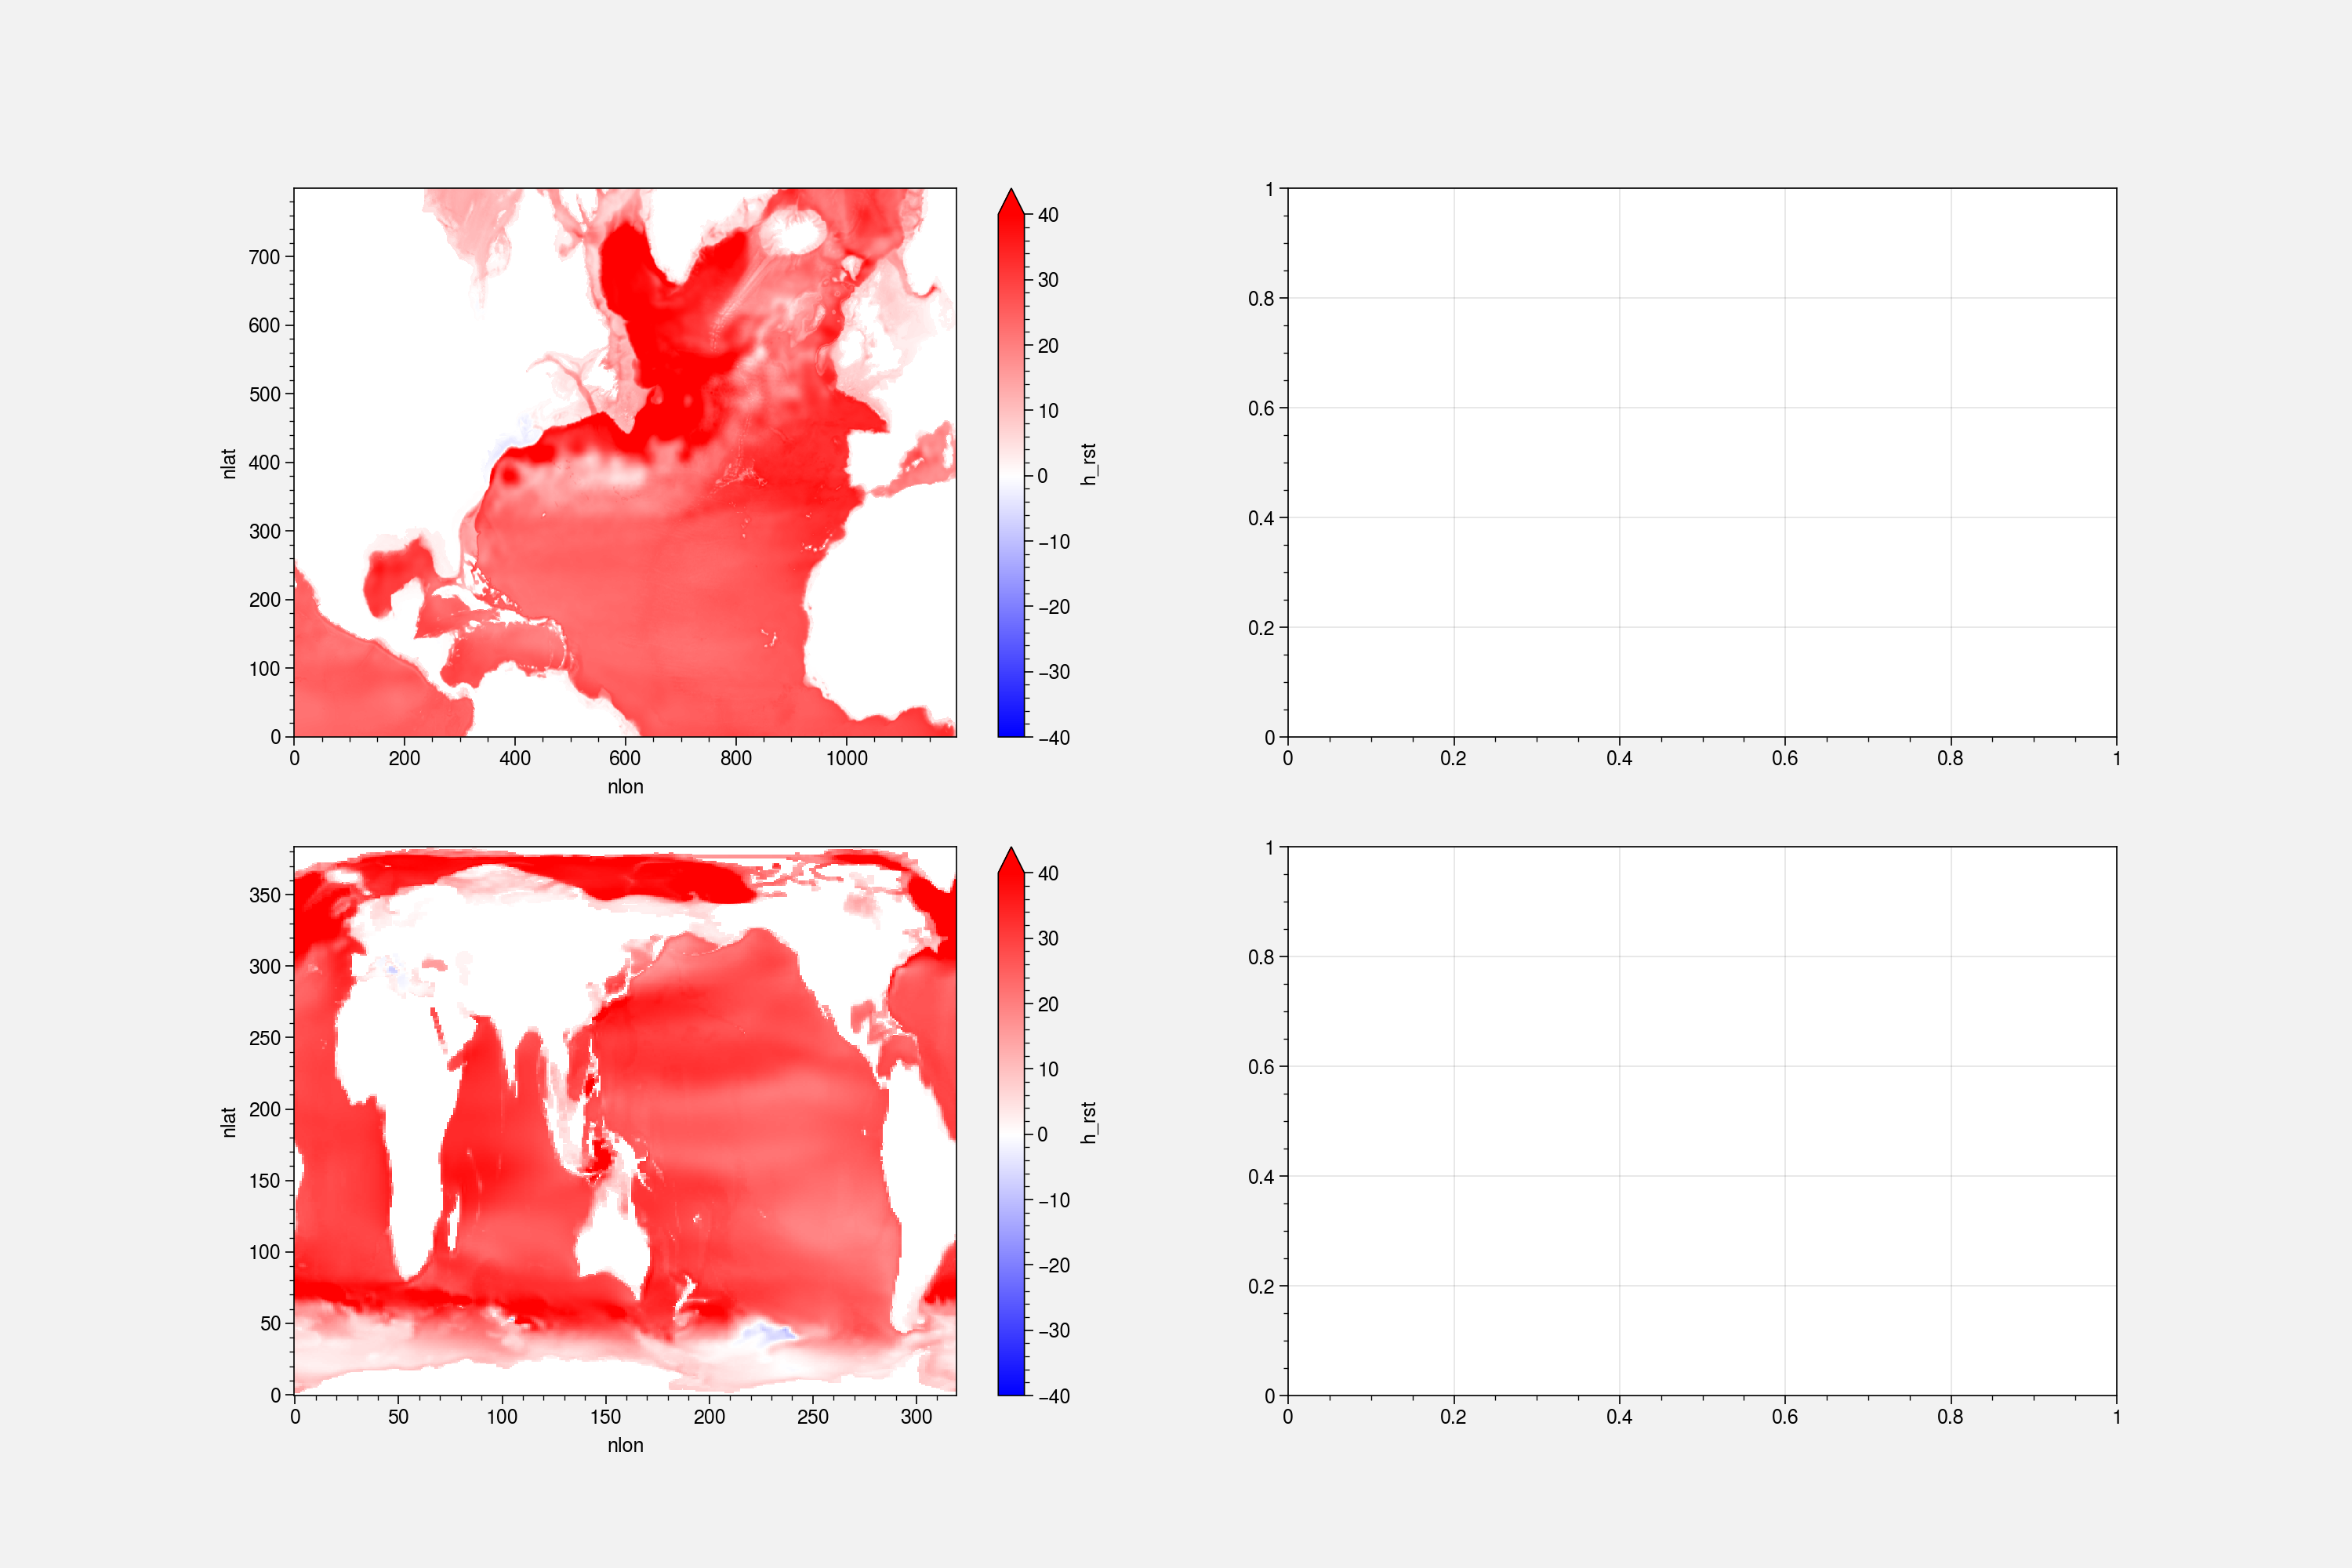

In [24]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
(dh_rst_TH.isel(nlon=slice(0,1200),nlat=slice(1200,2000))).plot(ax=axs[0,0],vmin=-40,vmax=40,cmap='bwr')
# (dh_rst_CH.isel(nlon=slice(0,1200),nlat=slice(1200,2000))).plot(ax=axs[0,1],vmin=-40,vmax=40,cmap='bwr')
# (dh_rst_TH-dh_rst_CH).isel(nlon=slice(0,1200),nlat=slice(1200,2000)).plot(ax=axs[1,0],vmin=-40,vmax=40,cmap='bwr')
(dh_rst_TL).plot(ax=axs[1,0],vmin=-40,vmax=40,cmap='bwr')
# (dh_rst_CL).plot(ax=axs[1,1],vmin=-40,vmax=40,cmap='bwr')
# (dh_rst_CL).plot(ax=axs[0,1],vmin=-40,vmax=40,cmap='bwr')
# (dh_rst_TL-dh_rst_CL).plot(ax=axs[1,0],vmin=-40,vmax=40,cmap='bwr')

<xarray.DataArray (nlat: 384, nlon: 321)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: nlat, nlon

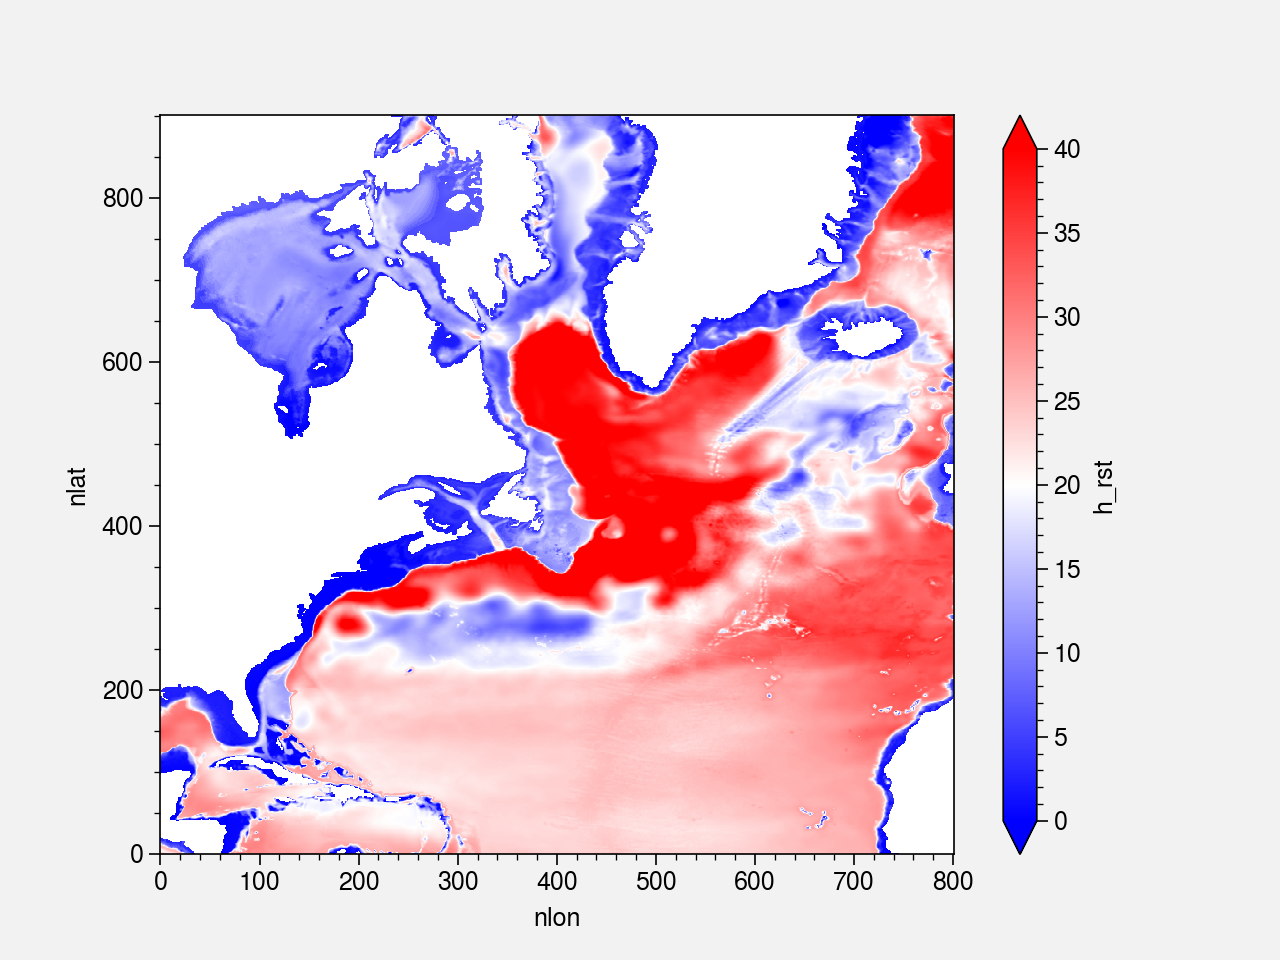

In [25]:
dh_rst_NA_TH = dh_rst_TH.isel(nlon=slice(200,1000+1),nlat=slice(1300,2200+1))
dh_rst_NA_TH.plot(vmin=0,vmax=40,cmap='bwr')
dh_rst_NA_TH

# dh_rst_TL.plot()
# bathy_NA_etopo
bathy_NA_t12 = ds0_HR.HT.isel(nlon=slice(200,1000+1),nlat=slice(1300,2200+1))/100 # [m]
bathy_NA_etopo_t12 = bathy_etopo_t12.isel(nlon=slice(200,1000+1),nlat=slice(1300,2200+1))
dpbathy_NA_t12Mobs = (bathy_NA_t12-bathy_NA_etopo_t12)/bathy_NA_etopo_t12
dpbathy_NA_t12Mobs 

dpbathy_g16Mobs = (ds0_g16_ac.HT/100-ds0_g16_ac.bathy_etopo_g16)/ds0_g16_ac.bathy_etopo_g16
dpbathy_g16Mobs

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super

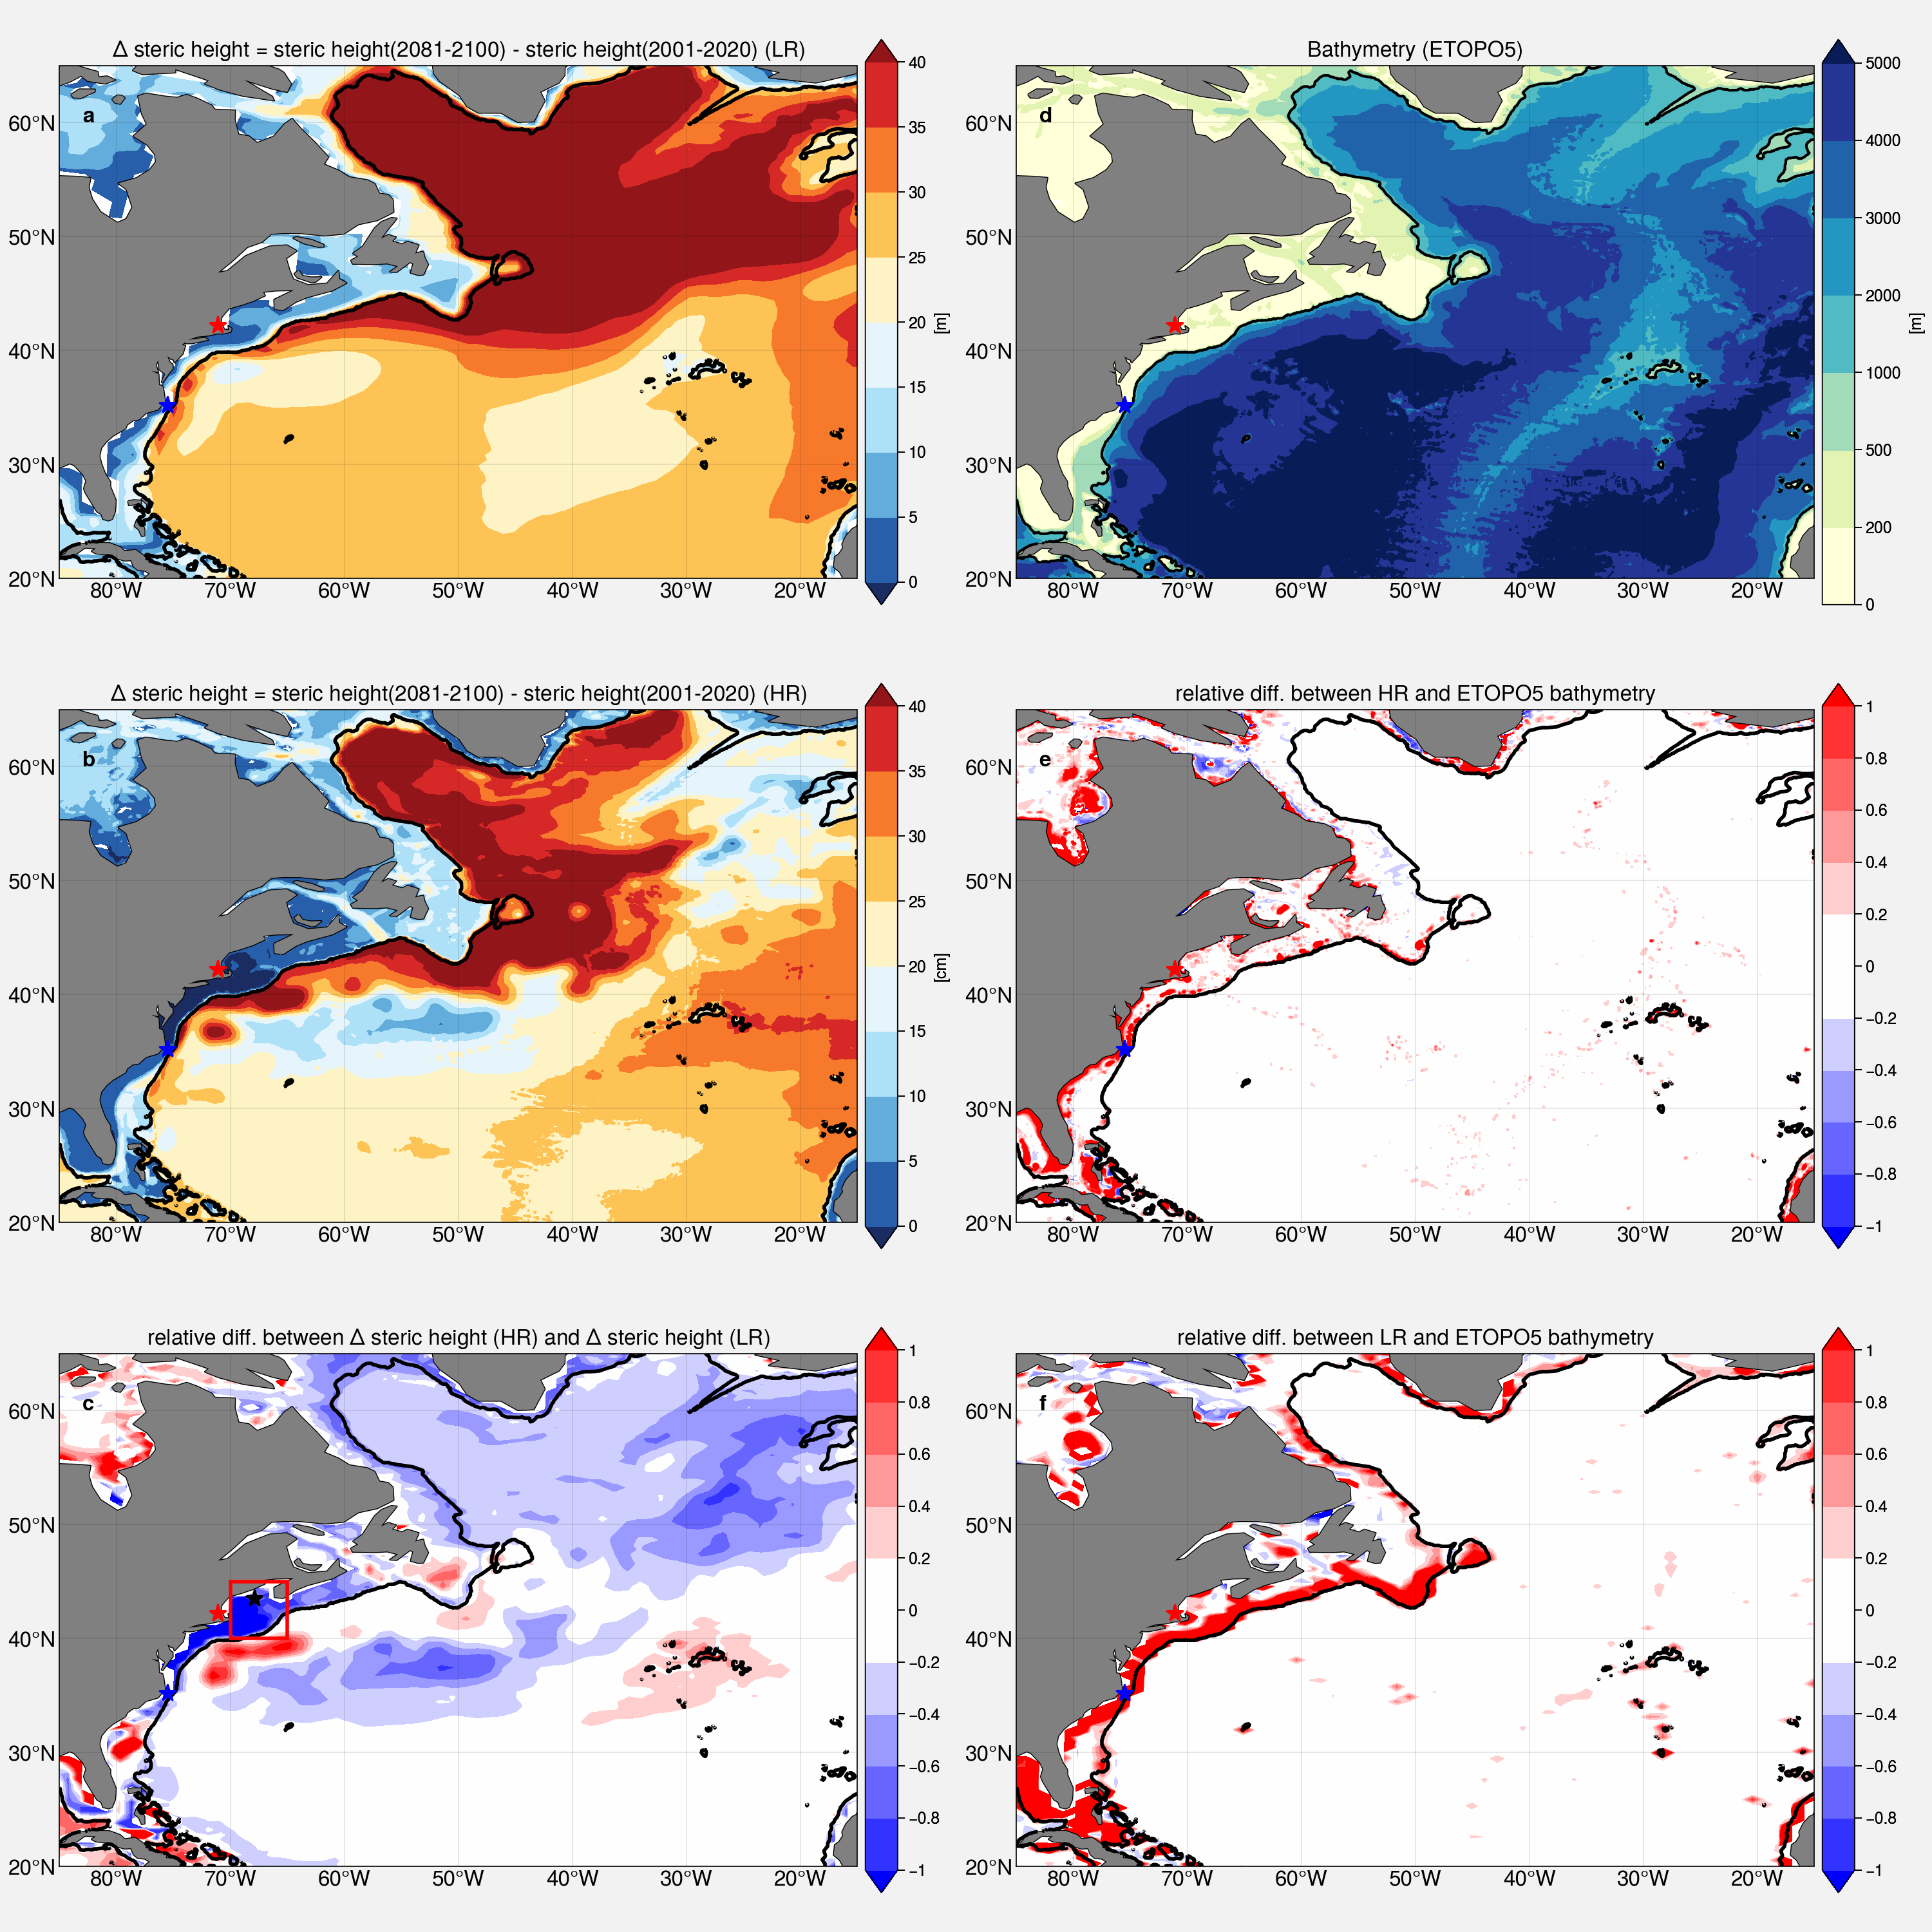

In [26]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=3, ncols=2, proj='cyl', width='15in', height='15in')

m00=axs[0,0].contourf(ds0_g16_ac.TLONG, ds0_g16_ac.TLAT, 
        ds0_g16_ac.dh_rst_TL, levels=np.arange(0,40+1,5), 
        transform=pc, vmin=0, vmax=40, cmap="ColdHot", extend='both')
axs[0,0].contour(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[1000], transform=pc, color='k', linewidth=2)
axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,0].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ steric height = steric height(2081-2100) - '
                   'steric height(2001-2020) (LR)', fontsize=12)
axs[0,0].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
cb = axs[0,0].colorbar(m00, loc='r', label='[m]', extend='both',width='2em',shrink=0.9)


m10=axs[1,0].contourf(dh_rst_NA_TH.TLONG, dh_rst_NA_TH.TLAT, 
        dh_rst_NA_TH, levels=np.arange(0,40+1,5), 
        transform=pc, vmin=0, vmax=40, cmap="ColdHot", extend='both')
axs[1,0].contour(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[1000], transform=pc, color='k',linewidth=2)
axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,0].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[1,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$\Delta$ steric height = steric height(2081-2100) - '
                   'steric height(2001-2020) (HR)', fontsize=12)
axs[1,0].text(-83, 60, 'b', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[1,0].colorbar(m10, loc='r', label='[cm]', extend='both',width='2em',shrink=0.9)


cut=-0.1
m20=axs[2,0].contourf(ds0_g16_ac.TLONG, ds0_g16_ac.TLAT, 
        ds0_g16_ac.dph_rst_THmTL, 
        levels=np.arange(-1,1+0.1,0.2), 
        transform=pc, vmin=-1, vmax=1, cmap="bwr", cmap_kw={'cut': cut}, extend='both')
axs[2,0].contour(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[1000], transform=pc, color='k',linewidth=2)
axs[2,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[2,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[2,0].plot(-67.88,43.49,transform=pc,marker='*',color='k',markersize=10)
# Buoy Mooring in Gulf of Maine (67.88W, 43.49N)
axs[2,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[2,0].format(land=True, landcolor='grey')
axs[2,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[2,0].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[2,0].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[2,0].xaxis.set_major_formatter(lon_formatter)
axs[2,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[2,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[2,0].yaxis.set_major_formatter(lat_formatter)
axs[2,0].set_title(r'relative diff. between $\Delta$ steric height (HR) and '
                   '$\Delta$ steric height (LR)', fontsize=12)

axs[2,0].text(-83, 60, 'c', transform=pc, fontsize=12, fontweight='bold')
cb = axs[2,0].colorbar(m20, loc='r', label='', extend='both',width='2em',shrink=0.9)
ap=axs[2,0].add_patch(mpatches.Rectangle(xy=[-70, 40], width=5, height=5,
                                    facecolor='none',
                                    transform=pc,
                                    linewidth=2, edgecolor='r'))
ap.set_zorder(2)


m01=axs[0,1].contourf(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[0,200,500,1000,2000,3000,4000,5000], 
        transform=pc, vmin=0, vmax=5000, cmap="ylgnbu", extend='max')# rdylbu
axs[0,1].contour(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[1000], transform=pc, color='k')
axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,1].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title('Bathymetry (ETOPO5)', fontsize=12)
axs[0,1].text(-83, 60, 'd', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label='[m]',width='2em',shrink=0.9)


m11=axs[1,1].contourf(dpbathy_NA_t12Mobs.lon, dpbathy_NA_t12Mobs.lat, dpbathy_NA_t12Mobs, 
        levels=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],
        transform=pc, vmin=-1, vmax=1, cmap="bwr", cmap_kw={'cut': cut}, extend='both')
axs[1,1].contour(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[1000], transform=pc, color='k',linewidth=2)
axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,1].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[1,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title('relative diff. between HR and ETOPO5 bathymetry', fontsize=12)
axs[1,1].text(-83, 60, 'e', transform=pc, fontsize=12, fontweight='bold')
cb = axs[1,1].colorbar(m11, loc='r', label='', extend='both',width='2em',shrink=0.9)

# row 2: 
m21=axs[2,1].contourf(ds0_g16_ac.TLONG, ds0_g16_ac.TLAT, dpbathy_g16Mobs,
        levels=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],
        transform=pc, vmin=-1, vmax=1, cmap="bwr", cmap_kw={'cut': cut}, extend='both')
axs[2,1].contour(bathy_NA_etopo.lon, bathy_NA_etopo.lat, 
bathy_NA_etopo, levels=[1000], transform=pc, color='k', linewidth=2)
axs[2,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[2,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[2,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[2,1].format(land=True, landcolor='grey')
axs[2,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[2,1].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[2,1].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[2,1].xaxis.set_major_formatter(lon_formatter)
axs[2,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[2,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[2,1].yaxis.set_major_formatter(lat_formatter)
axs[2,1].set_title('relative diff. between LR and ETOPO5 bathymetry', fontsize=12)
axs[2,1].text(-83, 60, 'f', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[2,1].colorbar(m21, loc='r', label='', extend='both',width='2em',shrink=0.9)

fig1.savefig(pic1,bbox_inches='tight')

# Appendix

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super

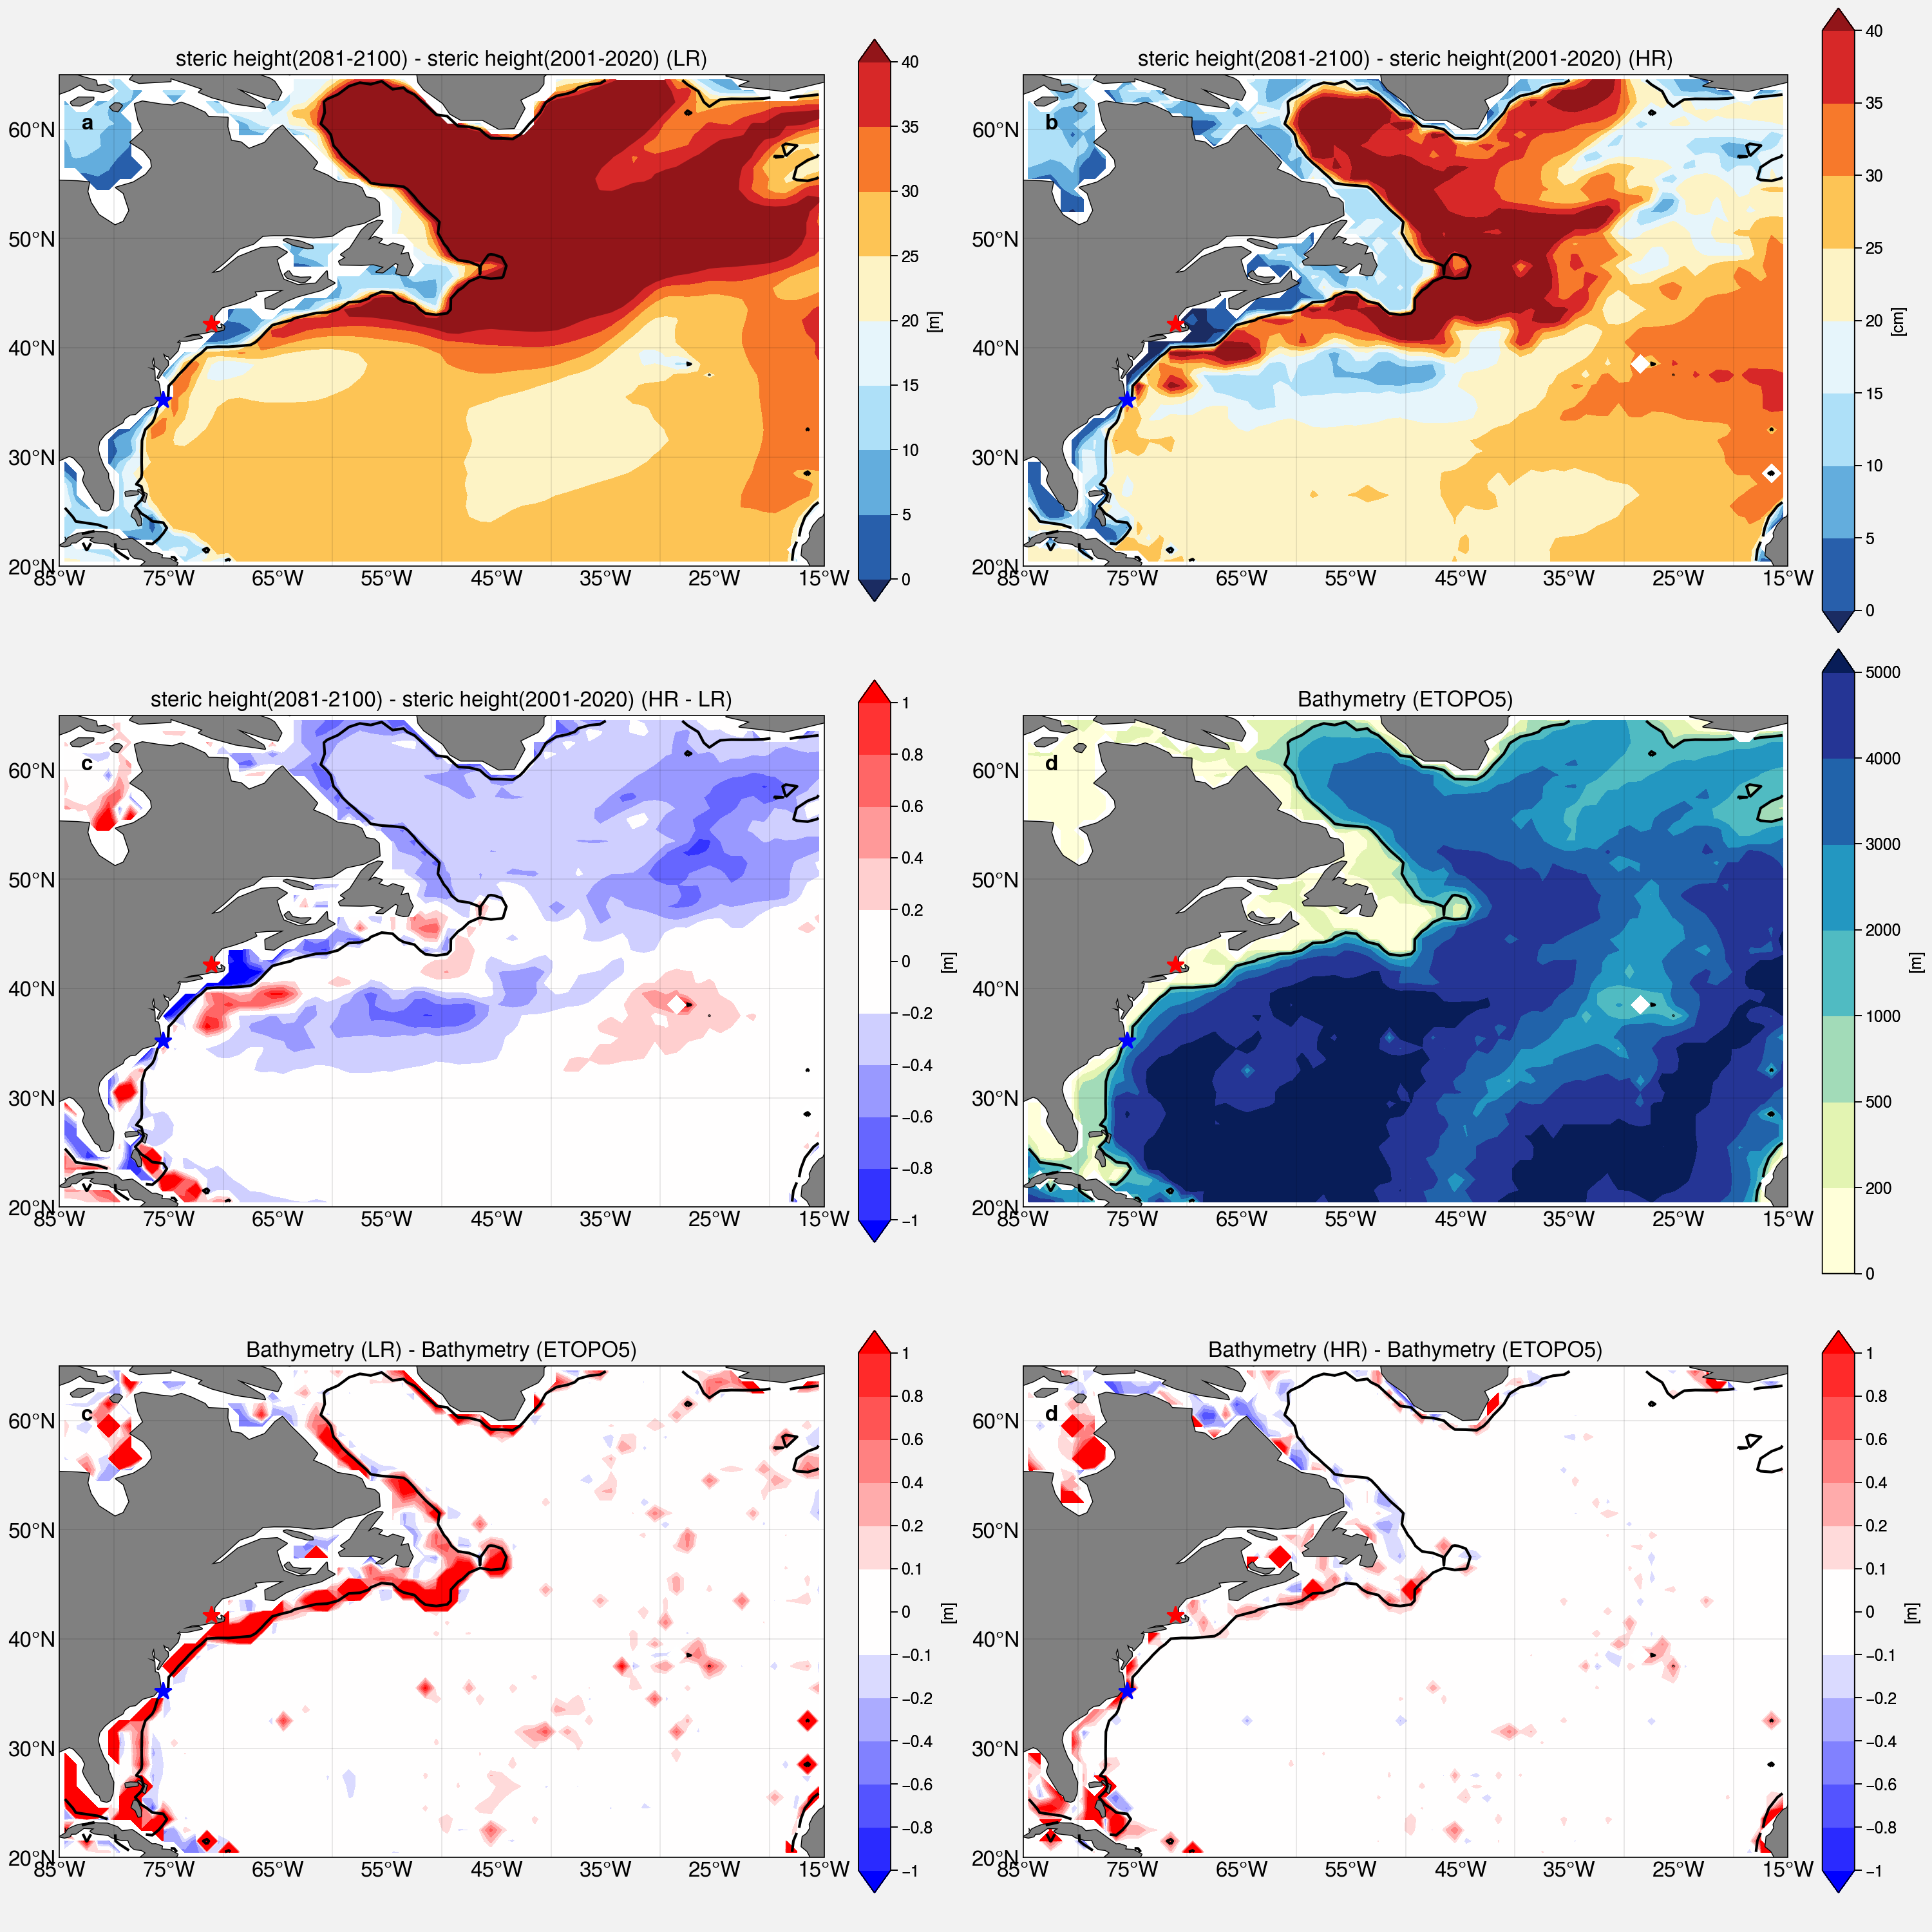

In [54]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=3, ncols=2, proj='cyl', width='15in', height='15in')

# row 1: 
m00=axs[0,0].contourf(dh_rst_rgd_NA_TL.lon, dh_rst_rgd_NA_TL.lat, 
        dh_rst_rgd_NA_TL, levels=np.arange(0,40+1,5), 
        transform=pc, vmin=0, vmax=40, cmap="ColdHot", extend='both')
axs[0,0].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='k')
axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,0].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title('steric height(2081-2100) - steric height(2001-2020) (LR)', fontsize=12)
axs[0,0].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
cb = axs[0,0].colorbar(m00, loc='r', label='[m]', extend='both',width='2em',shrink=0.9)

m01=axs[0,1].contourf(dh_rst_rgd_NA_TH.lon, dh_rst_rgd_NA_TH.lat, 
        dh_rst_rgd_NA_TH, levels=np.arange(0,40+1,5), 
        transform=pc, vmin=0, vmax=40, cmap="ColdHot", extend='both')
axs[0,1].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='k')
axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,1].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title('steric height(2081-2100) - steric height(2001-2020) (HR)', fontsize=12)
axs[0,1].text(-83, 60, 'b', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[0,1].colorbar(m01, loc='r', label='[cm]', extend='both',width='2em',shrink=1)


# m10=axs[1,0].contourf(dh_rst_rgd_NA_TH.lon, dh_rst_rgd_NA_TH.lat, 
#         (dh_rst_rgd_NA_TH-dh_rst_rgd_NA_TL).where(bathy_etopo_NA_rgd<3000,np.nan), 
#         levels=np.arange(-10,10+1,2), 
#         transform=pc, vmin=-10, vmax=10, cmap="bwr", extend='both')
cut=-0.1
m10=axs[1,0].contourf(dh_rst_rgd_NA_TH.lon, dh_rst_rgd_NA_TH.lat, 
        (dh_rst_rgd_NA_TH-dh_rst_rgd_NA_TL)/dh_rst_rgd_NA_TL, 
        levels=np.arange(-1,1+0.1,0.2), 
        transform=pc, vmin=-1, vmax=1, cmap="bwr", cmap_kw={'cut': cut}, extend='both')
axs[1,0].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='k')
axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,0].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[1,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title('steric height(2081-2100) - steric height(2001-2020) (HR - LR)', fontsize=12)
axs[1,0].text(-83, 60, 'c', transform=pc, fontsize=12, fontweight='bold')
cb = axs[1,0].colorbar(m10, loc='r', label='[m]', extend='both',width='2em',shrink=0.9)

m11=axs[1,1].contourf(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[0,200,500,1000,2000,3000,4000,5000], 
        transform=pc, vmin=0, vmax=5000, cmap="ylgnbu", extend='max')# rdylbu
axs[1,1].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='k')
axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,1].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[1,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title('Bathymetry (ETOPO5)', fontsize=12)
axs[1,1].text(-83, 60, 'd', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[1,1].colorbar(m11, loc='r', label='[m]',width='2em',shrink=1)

# row 2: 
# m20=axs[2,0].contourf(HT_rgd_NA_LR.lon, HT_rgd_NA_LR.lat, 
# (HT_rgd_NA_LR-bathy_etopo_NA_rgd).where(HT_rgd_NA_LR<3000,np.nan), 
#         levels=[-400,-200,-100,-50,0,50,100,200,400], cmap_kw={'cut': -0.1},
#         transform=pc, vmin=-400, vmax=400, cmap="bwr", extend='both')
m20=axs[2,0].contourf(HT_rgd_NA_LR.lon, HT_rgd_NA_LR.lat, 
(HT_rgd_NA_LR-bathy_etopo_NA_rgd)/bathy_etopo_NA_rgd, 
        levels=[-1,-0.8,-0.6,-0.4,-0.2,-0.1,0,0.1,0.2,0.4,0.6,0.8,1],
        transform=pc, vmin=-1, vmax=1, cmap="bwr",  cmap_kw={'cut': -0.1}, extend='both')
axs[2,0].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='k')
axs[2,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[2,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[2,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[2,0].format(land=True, landcolor='grey')
axs[2,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[2,0].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[2,0].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[2,0].xaxis.set_major_formatter(lon_formatter)
axs[2,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[2,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[2,0].yaxis.set_major_formatter(lat_formatter)
axs[2,0].set_title('Bathymetry (LR) - Bathymetry (ETOPO5)', fontsize=12)
axs[2,0].text(-83, 60, 'c', transform=pc, fontsize=12, fontweight='bold')
cb = axs[2,0].colorbar(m20, loc='r', label='[m]', extend='both',width='2em',shrink=0.9)

# row 2: 
# m21=axs[2,1].contourf(HT_rgd_NA_HR.lon, HT_rgd_NA_HR.lat, 
# (HT_rgd_NA_HR-bathy_etopo_NA_rgd).where(HT_rgd_NA_LR<3000,np.nan), 
#         levels=[-400,-200,-100,-50,0,50,100,200,400], cmap_kw={'cut': -0.1},
#         transform=pc, vmin=-400, vmax=400, cmap="bwr", extend='both')
m21=axs[2,1].contourf(HT_rgd_NA_HR.lon, HT_rgd_NA_HR.lat, 
(HT_rgd_NA_HR-bathy_etopo_NA_rgd)/bathy_etopo_NA_rgd, cmap_kw={'cut': -0.1},
        levels=[-1,-0.8,-0.6,-0.4,-0.2,-0.1,0,0.1,0.2,0.4,0.6,0.8,1],
        transform=pc, vmin=-1, vmax=1, cmap="bwr", extend='both')
axs[2,1].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='k')
axs[2,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[2,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[2,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[2,1].format(land=True, landcolor='grey')
axs[2,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[2,1].set_xticks(np.arange(-80,-20+1,10), crs=pc)
axs[2,1].set_xticklabels(np.arange(-80,-20+1,10), fontsize=12)
axs[2,1].xaxis.set_major_formatter(lon_formatter)
axs[2,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[2,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[2,1].yaxis.set_major_formatter(lat_formatter)
axs[2,1].set_title('Bathymetry (HR) - Bathymetry (ETOPO5)', fontsize=12)
axs[2,1].text(-83, 60, 'd', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[2,1].colorbar(m21, loc='r', label='[m]', extend='both',width='2em',shrink=0.9)

# fig1.savefig(pic1,bbox_inches='tight')

In [ ]:
# ds0_HR.HT.plot()


# # a=ds0_LR.RHO.isel(time=0,z_t=0,nlon=slice(260,320+1),nlat=slice(250,384+1))
# ht=ds0_HR.HT.isel(nlon=slice(200,1000+1),nlat=slice(1300,1800+1))
# ht.plot()
# ht

# pc = cartopy.crs.PlateCarree()
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()

# fig1, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', width='8in', height='8in')

# # # row 1: 
# m00=axs.contourf(ht.TLONG, ht.TLAT, 
#         ht/100, levels=np.arange(0,5000+1,500), 
#         transform=pc, vmin=0, vmax=5000, cmap="ColdHot", extend='both')
# m00=axs.scatter(ht.TLONG, ht.TLAT,s=0.01,
#         c='k', 
#         transform=pc, cmap="Reds")
# # cs00=axs[0,0].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
# # bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='b')
# # axs[0,0].clabel(cs00, inline=False, fmt='%d', fontsize=10)
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # # Boston (71.1W, 42.4N)
# # axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# # # Cape Hatters (75.5W, 35.2N)
# axs.coastlines(resolution='110m', color='black', linewidth=1)
# axs.format(land=True, landcolor='grey')
# axs[0,0].set_extent([280, 350, 10, 60], crs=pc)
# # axs[0,0].set_xticks(np.arange(-85,-15+1,10), crs=pc)
# # axs[0,0].set_xticklabels(np.arange(-85,-15+1,10), fontsize=12)
# # axs[0,0].xaxis.set_major_formatter(lon_formatter)
# # axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
# # axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
# # axs[0,0].yaxis.set_major_formatter(lat_formatter)

In [ ]:
# a=ds0_LR.RHO.isel(time=0,z_t=0,nlon=slice(260,320+1),nlat=slice(250,384+1))
# ht=ds0_LR.HT.isel(nlon=slice(260,320+1),nlat=slice(250,384+1))
# a.plot()
# a


# ds0_LR.nlon.isel(nlon=slice(260,320+1))


# a.TLONG.plot()
# a.TLAT.plot()

# a.nlon

# pc = cartopy.crs.PlateCarree()
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()

# fig1, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', width='8in', height='8in')

# # # row 1: 
# m00=axs.contourf(a.TLONG, a.TLAT, 
#         ht/100, levels=np.arange(0,5000+1,500), 
#         transform=pc, vmin=0, vmax=5000, cmap="ColdHot", extend='both')
# m00=axs.scatter(a.TLONG, a.TLAT,s=2,
#         c='k', 
#         transform=pc, cmap="Reds")
# # cs00=axs[0,0].contour(bathy_etopo_NA_rgd.lon, bathy_etopo_NA_rgd.lat, 
# # bathy_etopo_NA_rgd, levels=[1000], transform=pc, color='b')
# # axs[0,0].clabel(cs00, inline=False, fmt='%d', fontsize=10)
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # # Boston (71.1W, 42.4N)
# # axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# # # Cape Hatters (75.5W, 35.2N)
# axs.coastlines(resolution='110m', color='black', linewidth=1)
# axs.format(land=True, landcolor='grey')
# axs[0,0].set_extent([250, 320, 10, 90], crs=pc)
# # axs[0,0].set_xticks(np.arange(-85,-15+1,10), crs=pc)
# # axs[0,0].set_xticklabels(np.arange(-85,-15+1,10), fontsize=12)
# # axs[0,0].xaxis.set_major_formatter(lon_formatter)
# # axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
# # axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
# # axs[0,0].yaxis.set_major_formatter(lat_formatter)

In [ ]:
# ds_1deg = xe.util.grid_global(1, 1)
# ds_1deg

# weightfile_t12_1deg = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#                       'bilinear_t12_1x1degGlobalRectlinear_periodic_2020Aug01.nc')
# regridder_t12_1deg = xe.Regridder(ds0_t12_rn, ds_1deg, method='bilinear', periodic=True,
#                         filename=weightfile_t12_1deg, reuse_weights=True) # 
# regridder_t12_1deg

# weightfile_g16_1deg = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#                       'bilinear_g16_1x1degGlobalRectlinear_periodic_2020Aug01.nc')
# regridder_g16_1deg = xe.Regridder(ds0_g16_rn, ds_1deg, method='bilinear', periodic=True,
#                         filename=weightfile_g16_1deg, reuse_weights=True)
# # regridder_g16_1deg

# regridder_obs5mindeg_1deg = xe.Regridder(ds_etopo_rn, ds_1deg, method='bilinear', periodic=True,
#         filename='bilinear_obs0.08deg_1deg_Global_periodic_2021Apr28.nc', reuse_weights=True) # 
# regridder_obs5mindeg_1deg